# Predicting Newsletter Subscriptions Among Minecraft Players Using Gameplay Data

## Introduction

### Background
Understanding player behavior in online games is important for managing server resources, improving player experience, and guiding recruitment or marketing efforts. A research group in the Computer Science department at UBC has created a custom Minecraft server to study how players interact with the game. Players can voluntarily subscribe to a newsletter to receive updates about the project. Knowing which types of players are most likely to subscribe could help the research group focus their outreach efforts and predict engagement.
### Question
Can a player’s characteristics — such as age, gender, experience level, and total hours played — be used to predict whether or not they will subscribe to the game-related newsletter in the `players.csv` dataset?

The dataset we used is `players.csv`, which contains information on 196 unique Minecraft players who have interacted with the research server. Each row represents one player and includes demographic data, game experience, and subscription status.

There are 7 variables in the dataset:

| Variable        | Type     | Description                                                   |
|----------------|----------|---------------------------------------------------------------|
| experience      | Categorical (chr) | Player's experience level in Minecraft (e.g., Beginner, Pro)       |
| hashedEmail     | Categorical (chr) | A hashed ID for each unique player (not used in modeling)         |
| name            | Categorical (chr) | Player’s username (not used in modeling)                          |
| gender          | Categorical (chr) | Player's gender                                                   |
| played_hours    | Numeric (dbl)     | Total number of hours the player has spent playing Minecraft      |
| Age             | Numeric (dbl)     | Player's age in years                                             |
| subscribe       | Logical (lgl)     | Whether or not the player subscribed to the newsletter (`TRUE` or `FALSE`) |

We chose to focus on four explanatory variables: `Age`, `played_hours`, `gender`, and `experience`, and one response variable: `subscribe`. The variables `hashedEmail` and `name` were excluded from the analysis since they are identifiers and not relevant for prediction.

**Potential Issues:**
- The data may not be balanced across experience levels or subscription status.
- The sample size is small (n = 196), which may limit the model’s generalizability.
- Variables like gender and experience are self-reported and may contain noise or inconsistencies.

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [6]:
players <- read_csv("players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [23]:
sessions <- read_csv("sessions.csv")
sessions

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [26]:
players_clean <- players %>%

  filter(!is.na(Age), !is.na(played_hours)) %>%

  select(subscribe, Age, gender, experience, played_hours) %>%
  
  mutate(
    subscribe = as_factor(subscribe),
    gender = as_factor(gender),
    experience = as_factor(experience)
  )
players_clean

subscribe,Age,gender,experience,played_hours
<fct>,<dbl>,<fct>,<fct>,<dbl>
TRUE,9,Male,Pro,30.3
TRUE,17,Male,Veteran,3.8
FALSE,17,Male,Veteran,0.0
⋮,⋮,⋮,⋮,⋮
FALSE,22,Male,Veteran,0.3
FALSE,17,Prefer not to say,Amateur,0.0
FALSE,17,Male,Amateur,2.3


In [28]:
players_clean %>%
  count(subscribe)

players_clean %>%
  count(gender)

players_clean %>%
  count(experience)

players_clean %>%
  group_by(subscribe) %>%
  summarize(
    avg_age = mean(Age),
    med_age = median(Age),
    avg_playtime = mean(played_hours),
    med_playtime = median(played_hours),
    .groups = "drop"
  )
players_clean

subscribe,n
<fct>,<int>
FALSE,52
TRUE,142


gender,n
<fct>,<int>
Male,124
Female,37
Non-binary,15
Prefer not to say,11
Agender,2
Two-Spirited,5


experience,n
<fct>,<int>
Pro,13
Veteran,48
Amateur,63
Regular,35
Beginner,35


subscribe,avg_age,med_age,avg_playtime,med_playtime
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,22.98077,21,0.5019231,0.0
TRUE,19.61972,18,7.8830986,0.1


subscribe,Age,gender,experience,played_hours
<fct>,<dbl>,<fct>,<fct>,<dbl>
TRUE,9,Male,Pro,30.3
TRUE,17,Male,Veteran,3.8
FALSE,17,Male,Veteran,0.0
⋮,⋮,⋮,⋮,⋮
FALSE,22,Male,Veteran,0.3
FALSE,17,Prefer not to say,Amateur,0.0
FALSE,17,Male,Amateur,2.3


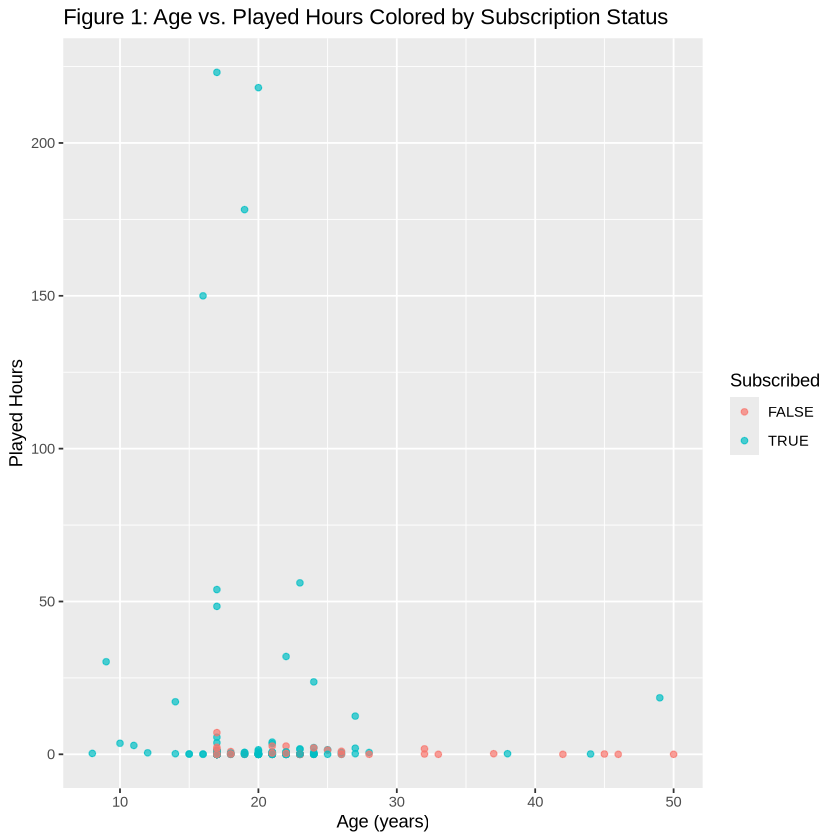

In [35]:
ggplot(players_clean, aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.7) +
  labs(
    title = "Figure 1: Age vs. Played Hours Colored by Subscription Status",
    x = "Age (years)",
    y = "Played Hours",
    color = "Subscribed"
  )

In [36]:
players_knn <- players_clean %>%
  select(subscribe, Age, played_hours, gender, experience)

set.seed(123)
player_split <- initial_split(players_knn, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

player_recipe <- recipe(subscribe ~ ., data = player_train) %>%
  step_normalize(all_numeric_predictors()) %>%
  step_dummy(all_nominal_predictors())

knn_spec <- nearest_neighbor(
  mode = "classification",
  neighbors = tune()
) %>%
  set_engine("kknn")

knn_workflow <- workflow() %>%
  add_model(knn_spec) %>%
  add_recipe(player_recipe)

In [37]:
set.seed(123)
player_folds <- vfold_cv(player_train, v = 5, strata = subscribe)

knn_results <- knn_workflow %>%
  tune_grid(
    resamples = player_folds,
    grid = tibble(neighbors = 1:20),  # trying k = 1 to 20
    metrics = metric_set(accuracy)
  )

best_k <- knn_results %>%
  select_best(metric = "accuracy")

final_knn <- knn_workflow %>%
  finalize_workflow(best_k) %>%
  fit(data = player_train)

In [38]:
knn_predictions <- predict(final_knn, player_test) %>%
  bind_cols(player_test)

metrics(knn_predictions, truth = subscribe, estimate = .pred_class)


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.71428571
kap,binary,-0.03939394


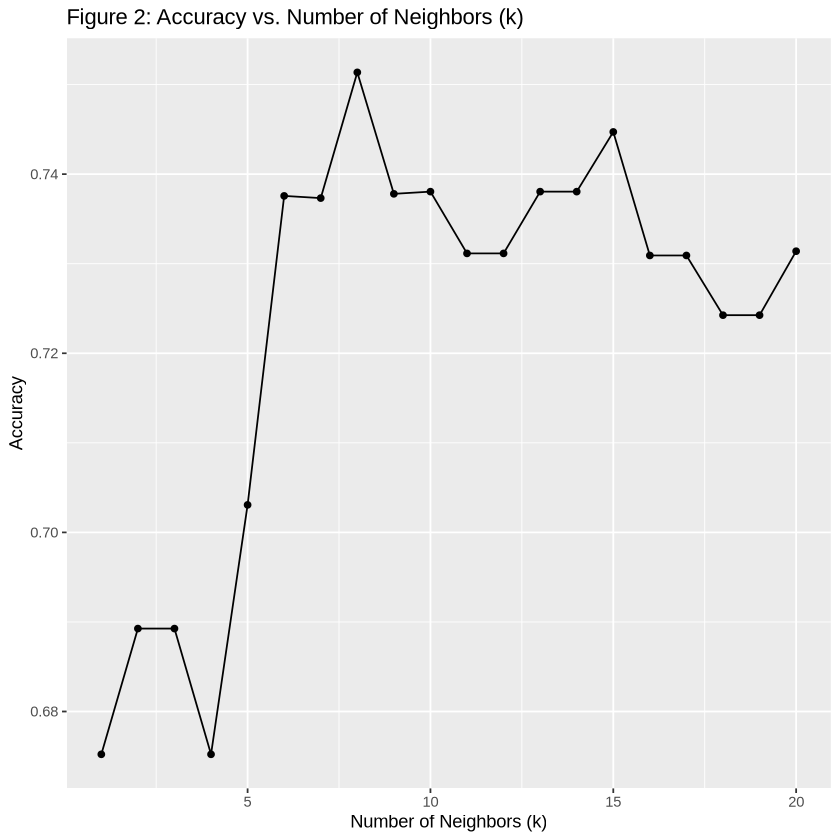

In [40]:
knn_results %>%
  collect_metrics() %>%
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line() +
  geom_point() +
  labs(
    title = "Figure 2: Accuracy vs. Number of Neighbors (k)",
    x = "Number of Neighbors (k)",
    y = "Accuracy"
  )